# Truncated Parabola: Data Generation and Gradient-Based Fitting

We use the truncated-parabola density (for $\alpha = 2$):

$$
\hat p(t) = \left[-\tau - \frac{(t-\mu)^2}{2\sigma^2}\right]_+,
\quad
\tau = -\frac12\left(\frac{3}{2\sigma}\right)^{2/3}.
$$

We generate synthetic data from this density and fit $(\mu,\sigma)$ by minimizing the attached loss:

$$
\ell(t_0;\mu,\sigma)
= \left[\frac12 - \frac{3}{10}\left(\frac{3}{2\sigma}\right)^{2/3}\right]_+
+ \frac{(t_0-\mu)^2}{2\sigma^2}.
$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

np.random.seed(7)
torch.manual_seed(7)


In [2]:
def tau_from_sigma(sigma):
    return -0.5 * (3.0 / (2.0 * sigma)) ** (2.0 / 3.0)


def density_truncated_parabola(t, mu, sigma):
    tau = tau_from_sigma(sigma)
    return np.maximum(-tau - (t - mu) ** 2 / (2.0 * sigma ** 2), 0.0)


def support_radius(sigma):
    # Radius r such that density is positive on [mu-r, mu+r]
    a = -tau_from_sigma(sigma)
    return np.sqrt(2.0 * sigma ** 2 * a)


def sample_truncated_parabola(mu, sigma, n, batch_size=4096):
    # Rejection sampling from the exact density.
    a = -tau_from_sigma(sigma)        # max density value
    r = support_radius(sigma)

    out = []
    while len(out) < n:
        x = np.random.uniform(mu - r, mu + r, size=batch_size)
        y = np.random.uniform(0.0, a, size=batch_size)
        fx = density_truncated_parabola(x, mu, sigma)
        accepted = x[y <= fx]
        out.extend(accepted.tolist())
    return np.array(out[:n])


In [3]:
# Ground-truth parameters for synthetic data
mu_true = 1.25
sigma_true = 0.9
n_samples = 4000

samples = sample_truncated_parabola(mu_true, sigma_true, n_samples)

print(f"Generated {len(samples)} samples")
print(f"sample mean = {samples.mean():.4f}, sample std = {samples.std():.4f}")


Generated 4000 samples
sample mean = 1.2456, sample std = 0.4809


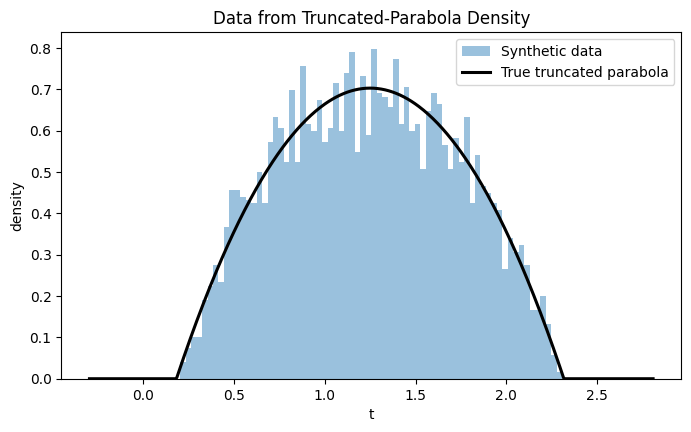

In [4]:
# Visualize histogram and true density
grid = np.linspace(samples.min() - 0.5, samples.max() + 0.5, 600)
f_true = density_truncated_parabola(grid, mu_true, sigma_true)

plt.figure(figsize=(8, 4.5))
plt.hist(samples, bins=70, density=True, alpha=0.45, color='tab:blue', label='Synthetic data')
plt.plot(grid, f_true, color='black', lw=2.2, label='True truncated parabola')
plt.title('Data from Truncated-Parabola Density')
plt.xlabel('t')
plt.ylabel('density')
plt.legend()
plt.show()


In [5]:
# Attached loss for one sample t0:
# ell(t0; mu, sigma) = relu(1/2 - 3/10 * (3/(2 sigma))^(2/3)) + (t0 - mu)^2 / (2 sigma^2)

def batch_loss(t, mu, sigma):
    term1 = torch.relu(0.5 - 0.3 * (3.0 / (2.0 * sigma)) ** (2.0 / 3.0))
    term2 = ((t - mu) ** 2).mean() / (2.0 * sigma ** 2)
    return term1 + term2


In [7]:
# Gradient-based fitting in PyTorch

t = torch.tensor(samples, dtype=torch.float32)

mu = torch.nn.Parameter(torch.tensor(0.0))
raw_sigma = torch.nn.Parameter(torch.tensor(0.0))  # sigma = softplus(raw_sigma) > 0
optimizer = torch.optim.Adam([mu, raw_sigma], lr=0.05)

history = []
for step in range(1200):
    optimizer.zero_grad()
    sigma = torch.nn.functional.softplus(raw_sigma) + 1e-6
    loss = batch_loss(t, mu, sigma)
    loss.backward()
    optimizer.step()

    history.append(float(loss.detach().cpu().item()))
    if step % 200 == 0:
        print(f"step {step:4d} | loss={history[-1]:.6f} | mu={mu.item():.4f} | sigma={sigma.item():.4f}")

mu_hat = float(mu.detach().cpu().item())
sigma_hat = float((torch.nn.functional.softplus(raw_sigma) + 1e-6).detach().cpu().item())

print('Estimated parameters')
print(f"mu_hat    = {mu_hat:.5f} (true {mu_true:.5f})")
print(f"sigma_hat = {sigma_hat:.5f} (true {sigma_true:.5f})")


step    0 | loss=1.855376 | mu=0.0500 | sigma=0.6931
step  200 | loss=0.221114 | mu=1.2456 | sigma=0.9313
step  400 | loss=0.221020 | mu=1.2456 | sigma=0.9105
step  600 | loss=0.221020 | mu=1.2456 | sigma=0.9105
step  800 | loss=0.221020 | mu=1.2456 | sigma=0.9105
step 1000 | loss=0.221020 | mu=1.2456 | sigma=0.9105
Estimated parameters
mu_hat    = 1.24562 (true 1.25000)
sigma_hat = 0.91049 (true 0.90000)


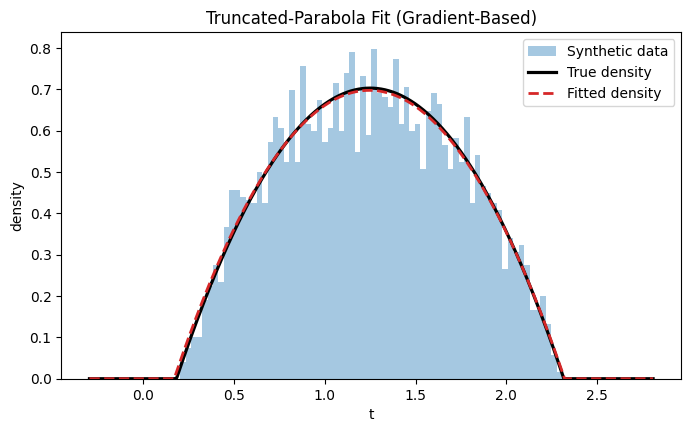

In [8]:
# Plot fitted density vs true density
f_fit = density_truncated_parabola(grid, mu_hat, sigma_hat)

plt.figure(figsize=(8, 4.5))
plt.hist(samples, bins=70, density=True, alpha=0.40, color='tab:blue', label='Synthetic data')
plt.plot(grid, f_true, color='black', lw=2.3, label='True density')
plt.plot(grid, f_fit, color='tab:red', lw=2.0, ls='--', label='Fitted density')
plt.title('Truncated-Parabola Fit (Gradient-Based)')
plt.xlabel('t')
plt.ylabel('density')
plt.legend()
plt.show()


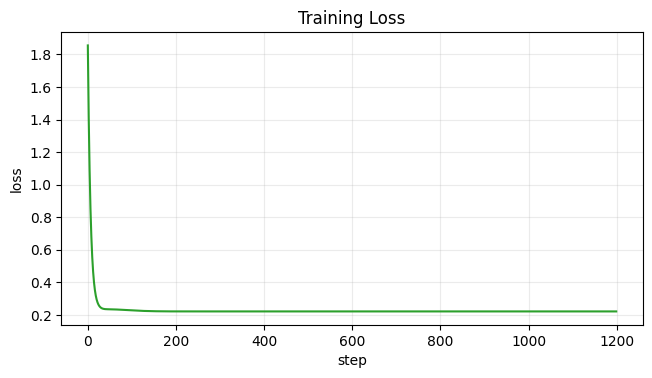

In [9]:
# Optimization trace
plt.figure(figsize=(7.5, 3.8))
plt.plot(history, color='tab:green')
plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.grid(alpha=0.25)
plt.show()
